In [261]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.radarmodule as radar
import pyPIPS.polarimetric as dualpol
#from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
from scipy.signal import medfilt2d
import pyart
import cartopy.crs as ccrs
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
radar_name = 'KHTX'
input_tag = 'filt_retr'
radar_type= 'NEXRAD'
date = '0430'
radar_start_timestamp = '20170430200000'
radar_end_timestamp = '20170430230000'

# Create datetime objects for start and end times
datetime_start = datetime.strptime(radar_start_timestamp, '%Y%m%d%H%M%S')
datetime_end = datetime.strptime(radar_end_timestamp, '%Y%m%d%H%M%S')

el_req = 0.5
gridded_radar_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/NEXRAD/PIPS2A_FMCW/0430/HTX/level2/Gridded'
gridded_radar_paths = glob.glob(gridded_radar_dir + '/{}20170430_2*gridded*.nc'.format(radar_name))

In [3]:
gridded_radar_paths = sorted(gridded_radar_paths)
gridded_radar = pyart.io.read_grid(gridded_radar_paths[0])

In [4]:
# Read in PIPS data
PIPS_data_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset_RB15/'
PIPS_filename = 'parsivel_combined_FMCW_2017_{}17_PIPS2A_60s.nc'.format(date)
PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
PIPS_ds = xr.load_dataset(PIPS_filepath)
print(PIPS_ds)

<xarray.Dataset>
Dimensions:                              (diameter_bin: 32, fallspeed_bin: 32, fields_KHTX: 64, parameter: 3, time: 1441)
Coordinates:
  * time                                 (time) datetime64[ns] 2017-04-30T00:...
    fallspeed                            (fallspeed_bin) float64 0.05 ... 20.8
    diameter                             (diameter_bin) float64 0.0625 ... 24.5
    min_diameter                         (diameter_bin) float64 0.0 ... 23.0
    max_diameter                         (diameter_bin) float64 0.125 ... 26.0
    min_fallspeeds                       (fallspeed_bin) float64 0.0 ... 19.2
    max_fallspeeds                       (fallspeed_bin) float64 0.1 ... 22.4
  * parameter                            (parameter) object 'N0' 'lamda' 'alpha'
  * fallspeed_bin                        (fallspeed_bin) float64 0.05 ... 20.8
  * diameter_bin                         (diameter_bin) float64 0.0625 ... 24.5
    flagged_times                        (time) int64 0 

In [5]:
PIPS_loc = eval(PIPS_ds.location)
PIPS_lat = PIPS_loc[0]
PIPS_lon = PIPS_loc[1]
print(PIPS_loc)
print(PIPS_lat, PIPS_lon)

(34.68711876893391, -86.00486430487216, 200.95575867737972)
34.68711876893391 -86.00486430487216


In [6]:
# heights of Grid levels
print(gridded_radar.metadata)
print(gridded_radar.point_z['data'][:, 10, 10])
print(gridded_radar.origin_altitude)

{'Conventions': 'CF/Radial instrument_parameters', 'version': '1.3', 'title': '', 'institution': '', 'references': '', 'source': '', 'history': '', 'comment': '', 'instrument_name': 'KHTX', 'original_container': 'NEXRAD Level II', 'vcp_pattern': 212}
[  500.   750.  1000.  1250.  1500.  1750.  2000.  2250.  2500.  2750.
  3000.  3250.  3500.  3750.  4000.  4250.  4500.  4750.  5000.  5250.
  5500.  5750.  6000.  6250.  6500.  6750.  7000.  7250.  7500.  7750.
  8000.  8250.  8500.  8750.  9000.  9250.  9500.  9750. 10000.]
{'long_name': 'Altitude at grid origin', 'units': 'm', 'standard_name': 'altitude', 'data': masked_array(data=[566.],
             mask=False,
       fill_value=1e+20)}


In [7]:
# ZH_mask = np.ma.masked_where(gridded_radar.fields['reflectivity']['data'] < 0., 
#                              gridded_radar.fields['reflectivity']['data'])
ZH_mask = np.where(gridded_radar.fields['reflectivity']['data'] < 5., True, False)
ZH_mask = np.where(np.isfinite(gridded_radar.fields['reflectivity']['data']), ZH_mask, False)
ZDR_mask = np.where(gridded_radar.fields['differential_reflectivity']['data'] < 0.1, True, False)
ZDR_mask = np.where(np.isfinite(gridded_radar.fields['reflectivity']['data']), ZDR_mask, False)
full_mask = np.ma.mask_or(ZH_mask, ZDR_mask)
# full_mask = np.ma.mask_or(ZH_mask, ZDR_mask)
for field_name in ['reflectivity', 'differential_reflectivity']:
    field_name_masked = '{}_masked'.format(field_name)
    dic = {}
    for k, v in gridded_radar.fields[field_name].items():
        if k != 'data':
            dic[k] = v
        dic['data'] = gridded_radar.fields[field_name]['data'].copy()
    gridded_radar.add_field(field_name_masked, dic, replace_existing=True)
    gridded_radar.fields[field_name_masked]['data'] = \
            np.ma.masked_array(gridded_radar.fields[field_name]['data'], mask=full_mask)

(241, 241)


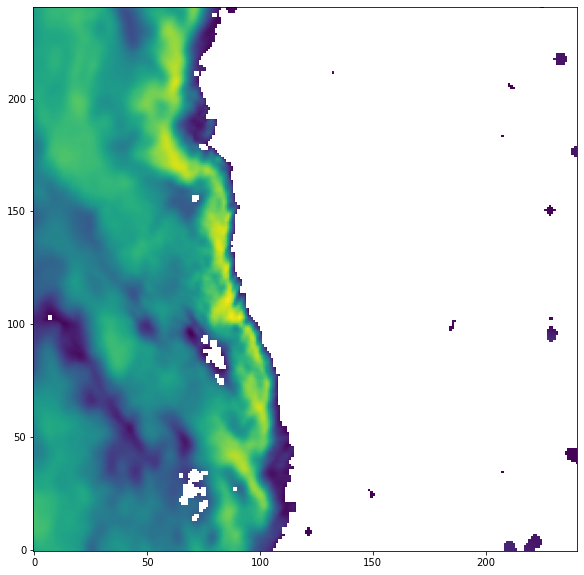

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
print(gridded_radar.fields['reflectivity_masked']['data'][0].shape)
ax.imshow(gridded_radar.fields['reflectivity_masked']['data'][0], origin='lower')

In [9]:
def roundPartial(value, resolution, decimals=4):
    return np.around(np.round(value / resolution) * resolution, decimals=decimals)
retrieval_tag = 'Z01'
lookup_dir = os.path.join('/Users/dawson29/Projects/pyPIPS/data/lookups/', retrieval_tag)
print("Getting ZH and ZDR fields")
# Get the ZH and ZDR fields from the radar object
print(gridded_radar.fields.keys())
ZH_rad_field = gridded_radar.fields['reflectivity_masked']
ZDR_rad_field = gridded_radar.fields['differential_reflectivity_masked']
# print(ZH_rad_tuple)
# ZH_rad_tuple = radar.get_gridded_field_to_plot(gridded_radar, radar.REF_aliases)
# ZDR_rad_tuple = radar.get_gridded_field_to_plot(gridded_radar, radar.ZDR_aliases)
ZH_rad = ZH_rad_field['data']
ZDR_rad = ZDR_rad_field['data']
# Get the masks for both ZH_rad and ZDR_rad. These will be used later to mask the retrieved
# values
ZH_mask = ZH_rad.mask
ZDR_mask = ZDR_rad.mask
full_mask = np.ma.mask_or(ZH_mask, ZDR_mask)
# Read in first lookup table to get the interval between reflectivity and ZDR
lookup_path = os.path.join(lookup_dir, 'D0.csv')
retr_table = pd.read_csv(lookup_path, sep=',', header=0, index_col='dBZ')
# Massage the index and column labels to get rid of extraneous zeros
# Also convert column labels from strings to floats
retr_table.index = retr_table.index.to_series().apply(np.around, decimals=4)
retr_table.columns = [np.around(np.float(col), decimals=4) for col in retr_table.columns]

dBZ_lookup_min = retr_table.index[0]
dBZ_lookup_max = retr_table.index[-1]
ZDR_lookup_min = retr_table.columns[0]
ZDR_lookup_max = retr_table.columns[-1]
dBZ_intv = retr_table.index[1] - retr_table.index[0]
ZDR_intv = float(retr_table.columns[1]) - float(retr_table.columns[0])
# Replace masked entries in ZH_rad and ZDR_rad with the minimum value of the lookup table
ZH_rad = ZH_rad.filled(dBZ_lookup_min)
ZDR_rad = ZDR_rad.filled(ZDR_lookup_min)
# Now limit values to within lookup table limits
ZH_rad = np.where(ZH_rad < dBZ_lookup_min, dBZ_lookup_min, ZH_rad)
ZH_rad = np.where(ZH_rad > dBZ_lookup_max, dBZ_lookup_max, ZH_rad)
ZDR_rad = np.where(ZDR_rad < ZDR_lookup_min, ZDR_lookup_min, ZDR_rad)
ZDR_rad = np.where(ZDR_rad > ZDR_lookup_max, ZDR_lookup_max, ZDR_rad)
# Round ZH and ZDR fields from the radar object to the nearest interval
ZH_round = roundPartial(ZH_rad, dBZ_intv)
ZDR_round = roundPartial(ZDR_rad, ZDR_intv)
# Get the shape of the arrays for later, so we can reshape the flattened arrays of retrieved
# values
ZH_shape = ZH_round.shape
ZH_flat = ZH_round.flatten()
ZDR_flat = ZDR_round.flatten()
print(ZH_flat.max())
print(ZDR_flat.max())
for retr_varname in radar.retrieval_metadata.keys():
    print("Retrieving {} using lookup tables".format(retr_varname))
    lookup_path = os.path.join(lookup_dir, '{}.csv'.format(retr_varname))
    retr_table = pd.read_csv(lookup_path, sep=',', header=0, index_col='dBZ')
    # Round the indices and columns of the DataFrame (i.e. the dBZ values) to some sane
    # number of decimal places to facilitate using it as a lookup table. The floating point
    # precision gets in the way sometimes here. For example 56.4 is dumped out as
    # 56.4<some bunch of zeros>1
    retr_table.index = retr_table.index.to_series().apply(np.around, decimals=4)
    retr_table.columns = [np.around(np.float(col), decimals=4) for col in
                          retr_table.columns]
    # Gah, for some reason DataFrame.lookup sometimes barfs on perfectly good floating point
    # values in columns, so convert them back to strings here. :rolleyes:
    # EDIT 11/09/2020: Now this is happening for the rows as well. Not sure why... So change the row labels
    # to strings as well.
    retr_table.index = [str(row) for row in retr_table.index]
    retr_table.columns = [str(col) for col in retr_table.columns]
    # print(list(retr_table.index))
    # print(list(retr_table.columns))
    # Ok, now retrieve the desired retrieval variable
    # for each ZH/ZDR pair in the flattened radar sweep
#     for ZH, ZDR in zip(ZH_flat, ZDR_flat):
#         print(ZH, ZDR)
#         retr_val = retr_table.lookup([ZH.astype('str')], [ZDR.astype('str')])
    retr_vals = retr_table.lookup(ZH_flat.astype('str'), ZDR_flat.astype('str'))
    # retr_vals = retr_table.lookup(ZH_flat, ZDR_flat)
    # Reshape back to original shape
    retr_vals_data = retr_vals.reshape(ZH_shape)
    retr_vals_data = np.ma.masked_array(retr_vals_data, mask=full_mask)
    # Construct the dictionary. NOTE: Gotcha! Apparently have to make a copy here,
    # otherwise contents of 'data' don't get written when same dictionary is used later.
    retr_val_dict = radar.retrieval_metadata[retr_varname].copy()
    retr_val_dict['data'] = retr_vals_data  # If I don't make a copy on the previous line
                                                    # The contents of retr_val_dict['data'] are
                                                    # not updated after the first time. This is
                                                    # very weird.
    # Save the retrieved array as a new field in the radar sweep object
    retr_varname_out = '{}_{}'.format(retr_varname, retrieval_tag)
    gridded_radar.add_field(retr_varname_out, retr_val_dict, replace_existing=True)
    # Now mask the retrieved values using the original combined mask of ZH and ZDR
    gridded_radar.fields[retr_varname_out]['data'].mask = full_mask

Getting ZH and ZDR fields
dict_keys(['differential_reflectivity', 'reflectivity', 'cross_correlation_ratio', 'ROI', 'reflectivity_masked', 'differential_reflectivity_masked'])
55.2
3.0
Retrieving D0 using lookup tables
Retrieving Dm using lookup tables
Retrieving N0 using lookup tables
Retrieving Nt using lookup tables
Retrieving RR using lookup tables
Retrieving W using lookup tables
Retrieving lamda using lookup tables
Retrieving mu using lookup tables
Retrieving sigma using lookup tables


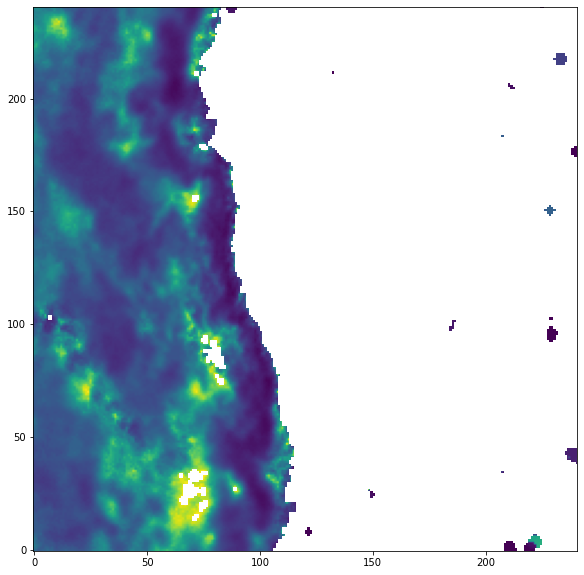

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(gridded_radar.fields['mu_Z01']['data'][0], origin='lower')

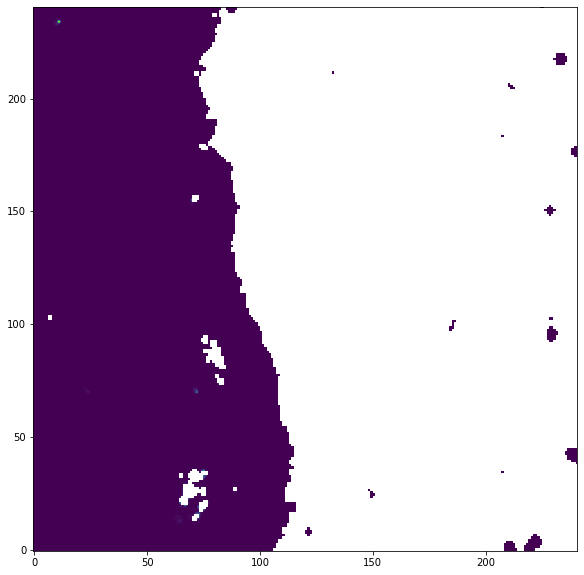

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(gridded_radar.fields['N0_Z01']['data'][0], origin='lower')

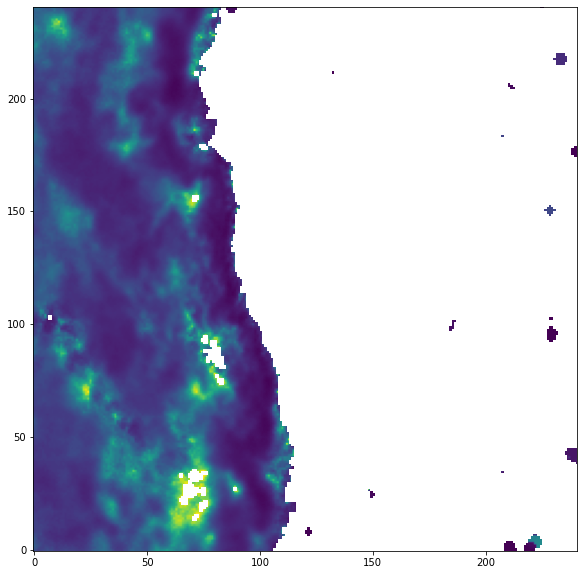

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(gridded_radar.fields['lamda_Z01']['data'][0], origin='lower')

In [13]:
# Extract one level within a small bounding box for testing
ibgn = 50
iend = 150
jbgn = 125
jend = 225
level = 2
z_level = gridded_radar.point_z['data'][level, 0, 0]
gridded_radar_xr = gridded_radar.to_xarray()
gridded_radar_subgrid = gridded_radar_xr.isel(time=0, x=slice(ibgn, iend), y=slice(jbgn, jend), z=level)
print(gridded_radar_subgrid)

<xarray.Dataset>
Dimensions:                           (x: 100, y: 100)
Coordinates:
    time                              object 2017-04-30 20:05:32.284000
    z                                 float64 1e+03
    lat                               (y) float64 34.97 34.98 ... 35.87 35.88
    lon                               (x) float64 -86.86 -86.85 ... -85.76
  * y                                 (y) float64 5.125e+03 ... 1.066e+05
  * x                                 (x) float64 -7.175e+04 ... 2.972e+04
Data variables:
    differential_reflectivity         (y, x) float32 0.7040956 ... nan
    reflectivity                      (y, x) float32 29.93678 30.236013 ... nan
    cross_correlation_ratio           (y, x) float32 0.9946982 0.9946915 ... nan
    ROI                               (y, x) float32 1933.6268 ... 2947.9116
    reflectivity_masked               (y, x) float32 29.93678 30.236013 ... nan
    differential_reflectivity_masked  (y, x) float32 0.7040956 ... nan
    D0_Z01   

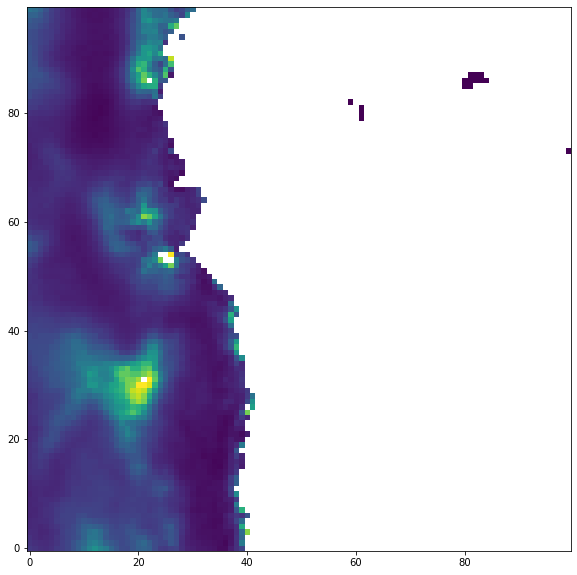

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(gridded_radar_subgrid['lamda_Z01'], origin='lower')

In [15]:
# Calculate ND for each grid point from gamma dist. parameters using Parsivel bins
avg_diameters = pp.parsivel_parameters['avg_diameter_bins_mm']
#avg_diameters = avg_diameters[:, np.newaxis, np.newaxis]
#avg_diameters = xr.DataArray(avg_diameters, dims=['diameter_bin', 'y', 'x'])
avg_diameters = xr.DataArray(avg_diameters, coords = {'diameter': ('diameter_bin', avg_diameters)}, 
                             dims=['diameter_bin'])

lamda = gridded_radar_subgrid['lamda_Z01'] * 1000. # get to m^-1
alpha = gridded_radar_subgrid['mu_Z01']
N0 = gridded_radar_subgrid['N0_Z01'] * 1000**(1 + alpha) # get to m^-4
ND = dsd.calc_binned_DSD_from_params(N0, lamda, alpha, avg_diameters) * 1.e-3 # Get to m^-3 mm^-1
ND.coords['max_diameter'] = ('diameter_bin', pp.parsivel_parameters['max_diameter_bins_mm'])
ND.coords['min_diameter'] = ('diameter_bin', pp.parsivel_parameters['min_diameter_bins_mm'])

In [16]:
print(ND[0, 0, :])

<xarray.DataArray (diameter_bin: 32)>
array([2.00710227e-01, 9.73847091e+00, 4.11992324e+01, 8.45287386e+01,
       1.21791583e+02, 1.42213756e+02, 1.44434139e+02, 1.32806968e+02,
       1.13354305e+02, 9.13128571e+01, 6.07012956e+01, 3.12988821e+01,
       1.46110844e+01, 6.33143604e+00, 2.58939767e+00, 6.22685434e-01,
       8.27570129e-02, 9.95780605e-03, 1.11221480e-03, 1.17243948e-04,
       3.68950615e-06, 3.25772789e-08, 2.60425874e-10, 1.93250046e-12,
       1.35341765e-14, 7.29332124e-18, 2.84245008e-22, 1.00295883e-26,
       3.28503133e-31, 1.01548306e-35, 2.19556881e-41, 3.24684129e-48])
Coordinates:
    time          object 2017-04-30 20:05:32.284000
    z             float64 1e+03
    lat           float64 34.97
    lon           float64 -86.86
    y             float64 5.125e+03
    x             float64 -7.175e+04
    diameter      (diameter_bin) float64 0.0625 0.1875 0.3125 ... 19.0 21.5 24.5
    max_diameter  (diameter_bin) float64 0.125 0.25 0.375 0.5 ... 20.0 23.0 2

In [17]:
# Recompute Z from ND to check
dBZ_retr = dsd.calc_dBZ_from_bins(ND)

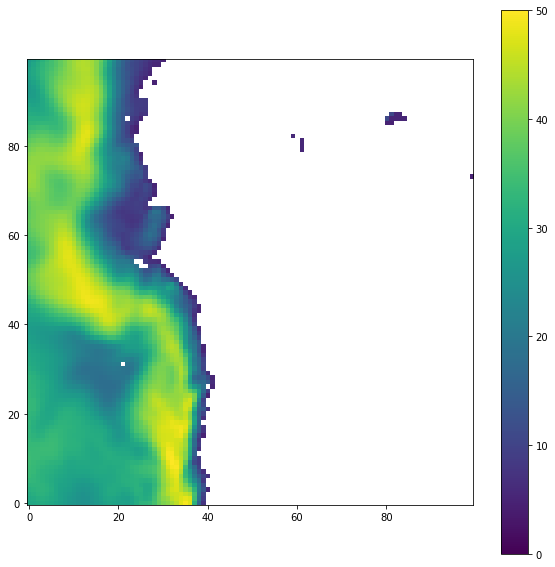

In [275]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
dBZ = ax.imshow(dBZ_retr, origin='lower', vmin=0., vmax=50.)
fig.colorbar(dBZ, ax=ax)

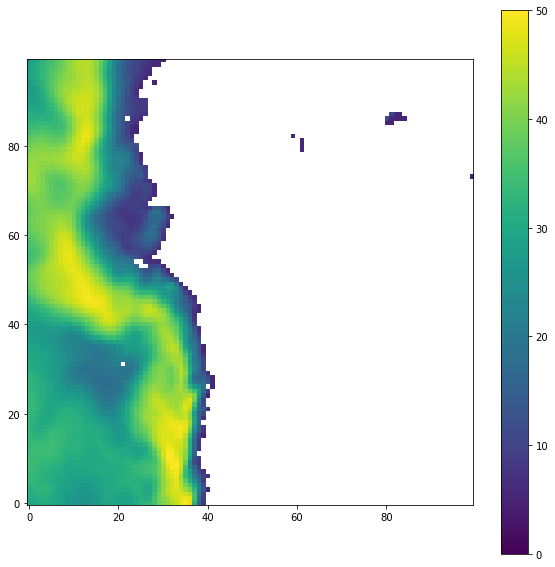

In [274]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
dBZ = ax.imshow(gridded_radar_subgrid['reflectivity_masked'], origin='lower', vmin=0., vmax=50.)
fig.colorbar(dBZ, ax=ax)

In [34]:
def rain_Brandes(D):
    """Given a range of diameters D, compute rain fall speed curve, a quartic polynomial
       fit after Brandes et al. (2002)."""
    
    D_mm=D*1000. # get it to (mm)
    
    Vtr = -0.1021 + 4.932*D_mm - 0.9551*D_mm**2. + 0.07934*D_mm**3. - 0.002362*D_mm**4.
    
    return Vtr

def cal_xf(usm,vsm,vt,H):
    """Computes final horizontal position (relative to starting position) of a raindrop
       falling through a layer H with terminal velocity vt and storm releative mean wind
       given by (usm,vsm)."""
    
    xf = (H/vt)*usm
    yf = (H/vt)*vsm
    
    return xf,yf


In [409]:
# print(gridded_radar_subgrid['x'])
grid_height = gridded_radar_subgrid['z'].values
# grid_height = 2000.
print(grid_height)
# print(gridded_radar.origin_altitude)

dz = 1.
heights = np.arange(0., grid_height + dz, dz)
D_max = 9.
D_range_full = ND['diameter'].values
D_max_ind = np.searchsorted(D_range_full, D_max)
D_range = D_range_full[:D_max_ind]
print(D_range)
ND_trunc = ND.isel(diameter_bin=slice(0, D_max_ind))
vt_range = rain_Brandes(D_range / 1000.)
print(vt_range)
# Set up a straight hodograph with 10 m/s of westerly shear over the depth
ug = 10.0*heights/grid_height
vg = np.zeros_like(ug)
# Storm motion
us = 20.
vs = 0.

# ug = 0.
# vg = 0.
# us = 0.
# vs = 0.

# Storm-relative winds
usr = ug - us
vsr = vg - vs
# Layer-mean storm-relative winds
usm = np.mean(usr)
vsm = np.mean(vsr)
print(usm, vsm)

# Interpolate ND to a finer grid
# Set up grid of locations
x_coords = ND_trunc['x']
y_coords = ND_trunc['y']

print(x_coords.sizes['x'])

new_x_coords = np.linspace(x_coords.x[0], x_coords.x[-1], x_coords.sizes['x'] * 4)
new_y_coords = np.linspace(y_coords.y[0], y_coords.y[-1], y_coords.sizes['y'] * 4)

ND_trunc = ND_trunc.interp(x=new_x_coords, y=new_y_coords)

x_grid, y_grid = np.meshgrid(x_coords, y_coords)
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

x_grid2, y_grid2 = xr.broadcast(ND_trunc['x'], ND_trunc['y'])
x_flat = x_grid2.stack(loc=['y', 'x'])
y_flat = y_grid2.stack(loc=['y', 'x'])
x_flat = x_flat.values
y_flat = y_flat.values
# Compute horizontal deviations of drops at bottom of layer for each grid point and drop size
xf, yf = cal_xf(usm, vsm, vt_range, grid_height)
print(xf, yf)
x_flat_f = x_flat[:, np.newaxis] + xf
y_flat_f = y_flat[:, np.newaxis] + yf

1000.0
[0.0625 0.1875 0.3125 0.4375 0.5625 0.6875 0.8125 0.9375 1.0625 1.1875
 1.375  1.625  1.875  2.125  2.375  2.75   3.25   3.75   4.25   4.75
 5.5    6.5    7.5    8.5   ]
[0.20243847 0.78959234 1.34827725 1.87939531 2.38383474 2.86246996
 3.31616154 3.7457562  4.15208682 4.53597247 5.07147419 5.71431825
 6.28142631 6.77868642 7.2117652  7.75289421 8.29872984 8.67865684
 8.92737921 9.07605796 9.17093988 9.17535487 9.16157188 9.20881488]
-15.000000000000002 0.0
100
[-74096.58673906 -18997.1447931  -11125.30820355  -7981.29055344
  -6292.38250135  -5240.22966237  -4523.30196376  -4004.53185143
  -3612.64121747  -3306.89837981  -2957.71987416  -2624.98505332
  -2387.99267378  -2212.81810081  -2079.93460331  -1934.76134098
  -1807.50552151  -1728.37805245  -1680.22435763  -1652.6998907
  -1635.60117114  -1634.81415208  -1637.2736256   -1628.87409548] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<xarray.DataArray (y: 400, x: 400)>
array([[ 997.82949054,  985.6490662 ,  973.46864185, ...,    0.        ,
           0.        ,    0.        ],
       [1001.75239915,  990.50173627,  979.25107339, ...,    0.        ,
           0.        ,    0.        ],
       [1005.67530775,  995.35440634,  985.03350492, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [1427.51673845, 1562.29268058, 1697.06862271, ...,    0.        ,
           0.        ,    0.        ],
       [1441.18521856, 1566.14496138, 1691.10470421, ...,    0.        ,
           0.        ,    0.        ],
       [1454.85369867, 1569.99724219, 1685.14078571, ...,    0.        ,
           0.        ,    0.        ]])
Coordinates:
    time     object 2017-04-30 20:05:32.284000
    z        float64 1e+03
    lat      (y) float64 34.97 34.97 34.97 34.98 ... 35.87 35.88 35.88 35.88
    lon      (x) float64 -86.86 -86.86 -86.85 -86.85 ... -85.77 -85.76 -85.76
  * x        (x) float64 -7.175e+04 -

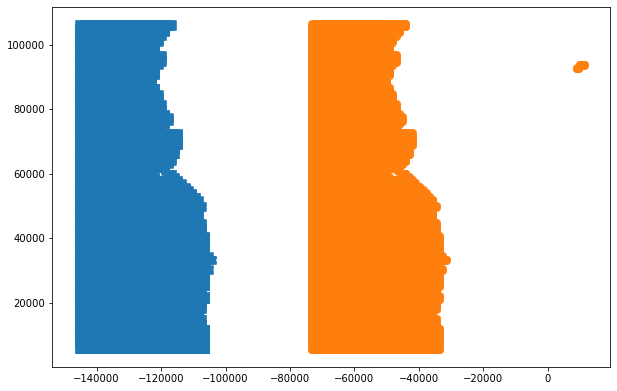

In [399]:
# TODO test plot of endpoints
Nt = ND_trunc.sum(dim='diameter_bin')
print(Nt)
Nt_flat = Nt.values.flatten()
indices = np.where(Nt_flat > 0.)[0]
x_flat_f_0 = x_flat_f[:, 0]
y_flat_f_0 = y_flat_f[:, 0]
x_flat_f_1 = x_flat_f[:, -1]
y_flat_f_1 = y_flat_f[:, -1]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x_flat_f_0[indices], y_flat_f_0[indices], marker='x')
ax.scatter(x_flat_f_1[indices], y_flat_f_1[indices], marker='o', alpha=0.5)
# ax.set_xlim(-40000., -30000.)
# ax.set_ylim(50000., 60000.)

ax.set_aspect('equal')

In [410]:
ND_trunc_2 = ND_trunc.transpose("y", "x", "diameter_bin")
ND_trunc_flat = ND_trunc_2.stack(loc=['y', 'x'])
ND_trunc_flat = ND_trunc_flat.transpose("loc", "diameter_bin")
ND_trunc_flat = ND_trunc_flat.where(ND_trunc_flat > 0., 0.)
ND_trunc_flat = ND_trunc_flat.where(np.isfinite(ND_trunc_flat), 0.0)

# Get polarimetric variables
dD = ND_trunc['max_diameter'] - ND_trunc['min_diameter']
print(dD)
dualpol_dict = dualpol.calpolrain(10.7, '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                  ND_trunc_flat, dD)
print(dualpol_dict['ZH_bin'])

# Get Rayleigh reflectivity for each precip trajectory endpoint
M6, M6_D_bins_flat = dsd.calc_moment_bin(ND_trunc_flat, moment=6)
# M6_D_bins = M6_D_bins.where(np.isfinite(M6_D_bins))
# M6_D_bins = M6_D_bins.transpose("y", "x", "diameter_bin")
# M6_D_bins_arr = M6_D_bins.values
# M6_D_bins_flat = M6_D_bins_arr.reshape(-1, M6_D_bins_arr.shape[-1])
#M6_D_bins_flat = M6_D_bins.stack(loc=['y', 'x'])
#print(M6_D_bins_flat)
M6_D_bins_flat = M6_D_bins_flat.transpose("loc", "diameter_bin")
dBZ_D_bins_flat = 10. * np.log10(1.e18 * M6_D_bins_flat)
dBZ_flat = 10. * np.log10(1.e18 * M6_D_bins_flat.sum(dim='diameter_bin'))
dBZ_D_bins_flat = dBZ_D_bins_flat.transpose("loc", "diameter_bin")
# dBZ_D_bins_flat = dBZ_D_bins_flat.where(np.isfinite(dBZ_D_bins_flat))

<xarray.DataArray (diameter_bin: 24)>
array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.25 , 0.25 , 0.25 , 0.25 , 0.25 , 0.5  , 0.5  , 0.5  ,
       0.5  , 0.5  , 1.   , 1.   , 1.   , 1.   ])
Coordinates:
    time          object 2017-04-30 20:05:32.284000
    z             float64 1e+03
    diameter      (diameter_bin) float64 0.0625 0.1875 0.3125 ... 6.5 7.5 8.5
    max_diameter  (diameter_bin) float64 0.125 0.25 0.375 0.5 ... 7.0 8.0 9.0
    min_diameter  (diameter_bin) float64 0.0 0.125 0.25 0.375 ... 6.0 7.0 8.0
Dimensions without coordinates: diameter_bin
<xarray.DataArray (loc: 160000, diameter_bin: 24)>
array([[1.49753468e-09, 5.29636698e-05, 4.80322970e-03, ...,
        2.81016492e-03, 4.83052154e-05, 6.39728869e-07],
       [1.93234636e-09, 5.78821740e-05, 4.97589551e-03, ...,
        5.16909511e-03, 1.13067779e-04, 1.97837008e-06],
       [2.36715804e-09, 6.28006783e-05, 5.14856133e-03, ...,
        7.52802529e-03, 1.77830343e-04, 3.317011

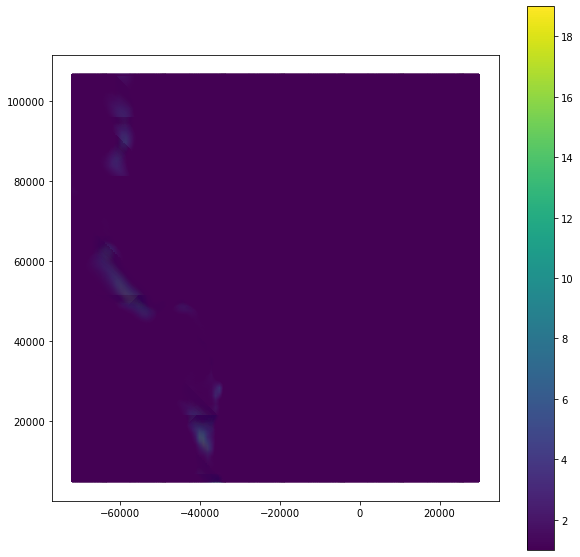

In [313]:
fig, ax = plt.subplots(figsize=(10,10))
clevels = np.arange(1., 20., 1.)
vmin = clevels[0]
vmax = clevels[-1]
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
dBZ_scatt = ax.scatter(x_flat_f, y_flat_f, marker='x', c=dualpol_dict['ZH_bin'], s=2, norm=norm)
#ax.scatter(x_flat_f, y_flat_f, marker='o', alpha=0.5)
# ax.set_xlim(-40000., -30000.)
# ax.set_ylim(50000., 60000.)
fig.colorbar(dBZ_scatt, ax=ax)
ax.set_aspect('equal')

In [418]:
dx_bins = 500.
dx_orig = new_x_coords[1] - new_x_coords[0]
print("dx (top), dx (bottom)", dx_orig, dx_bins)
area_ratio = dx_bins**2. / dx_orig**2.
print("area ratio: ", area_ratio)
# Get bounding box of bottom of domain
xmin = int(x_flat_f.min()) # -5000.
xmax = int(x_flat_f.max())
ymin = int(y_flat_f.min()) # -5000.
ymax = int(y_flat_f.max())

# Create bins for bottom of domain
xbins = int((xmax-xmin)/dx_bins)
ybins = int((ymax-ymin)/dx_bins)

print(xbins)
print(ybins)
xmax = xmin+dx_bins*xbins # +5000.
ymax = ymin+dx_bins*ybins # +5000.
print(xmin, xmax, ymin, ymax)

dx (top), dx (bottom) 254.323308270672 500.0
area ratio:  3.86516181227136
347
202
-145846 27654.0 5125 106125.0


In [419]:


# Create 2D histogram of reflectivity for endpoints of drop trajectories
# M6_bins, xedges, yedges = np.histogram2d(x_flat_f.flatten(), y_flat_f.flatten(),
#                                          bins=[xbins, ybins],
#                                          range=[[xmin, xmax], [ymin, ymax]], 
#                                          weights=M6_D_bins_flat.values.flatten())
# M6_bins, xedges, yedges = np.histogram2d(x_flat_f.flatten(), y_flat_f.flatten(),
#                                          bins=[xbins, ybins],
#                                          range=[[xmin, xmax], [ymin, ymax]],
#                                          weights=M6_D_bins_flat.values.flatten())

ZH_bins, xedges, yedges = np.histogram2d(x_flat_f.flatten(), y_flat_f.flatten(),
                                         bins=[xbins, ybins],
                                         range=[[xmin, xmax], [ymin, ymax]],
                                         weights=dualpol_dict['ZH_bin'].values.flatten())

ZV_bins, xedges, yedges = np.histogram2d(x_flat_f.flatten(), y_flat_f.flatten(),
                                         bins=[xbins, ybins],
                                         range=[[xmin, xmax], [ymin, ymax]],
                                         weights=dualpol_dict['ZV_bin'].values.flatten())

# Need to scale by the area ratio between the top and bottom grids
# M6_bins = M6_bins / area_ratio
ZH_bins = ZH_bins / area_ratio
ZV_bins = ZV_bins / area_ratio

print(xedges)
print(yedges)
# dBZBin = M6_bins
dBZBin = 10. * np.log10(ZH_bins)
ZDRBin = 10. * np.log10(ZH_bins / ZV_bins)
# dBZBin = 10. * np.log10(1.e18 * M6_bins)
print(np.nanmax(dBZBin), np.nanmin(dBZBin))
print(dBZBin)

[-145846. -145346. -144846. -144346. -143846. -143346. -142846. -142346.
 -141846. -141346. -140846. -140346. -139846. -139346. -138846. -138346.
 -137846. -137346. -136846. -136346. -135846. -135346. -134846. -134346.
 -133846. -133346. -132846. -132346. -131846. -131346. -130846. -130346.
 -129846. -129346. -128846. -128346. -127846. -127346. -126846. -126346.
 -125846. -125346. -124846. -124346. -123846. -123346. -122846. -122346.
 -121846. -121346. -120846. -120346. -119846. -119346. -118846. -118346.
 -117846. -117346. -116846. -116346. -115846. -115346. -114846. -114346.
 -113846. -113346. -112846. -112346. -111846. -111346. -110846. -110346.
 -109846. -109346. -108846. -108346. -107846. -107346. -106846. -106346.
 -105846. -105346. -104846. -104346. -103846. -103346. -102846. -102346.
 -101846. -101346. -100846. -100346.  -99846.  -99346.  -98846.  -98346.
  -97846.  -97346.  -96846.  -96346.  -95846.  -95346.  -94846.  -94346.
  -93846.  -93346.  -92846.  -92346.  -91846.  -913

In [420]:
def mtokm(val,pos):
    """Convert m to km for formatting axes tick labels"""
    val=val/1000.0
    return '%i' % val

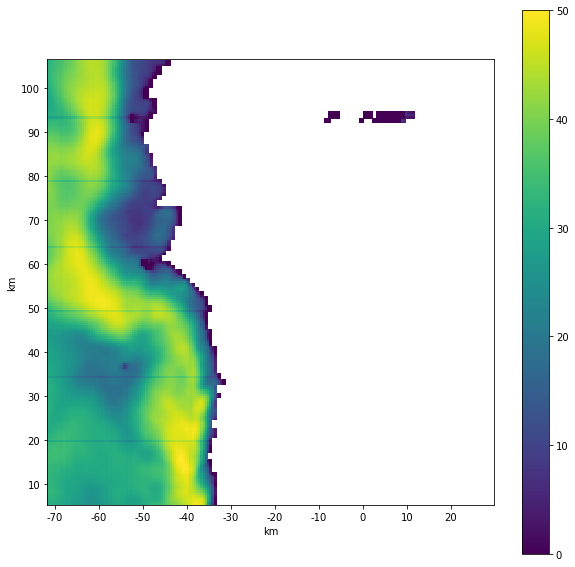

In [421]:
fig, ax = plt.subplots(figsize=(10, 10))
plotvarBin = dBZBin 

clevels = np.arange(0., 55., 5.)
vmin = clevels[0]
vmax = clevels[-1]
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
# plotvarBin = np.ma.masked_invalid(plotvarBin)
# plotvarBin = np.ma.masked_outside(plotvarBin, vmin, vmax)
    #plot=ax.pcolormesh(xedges,yedges,DmperBin.T,vmin=vmin,vmax=vmax,cmap=cm.jet,norm=norm,edgecolors='None',antialiased=False,rasterized=False)
plot=ax.pcolormesh(xedges, yedges, plotvarBin.T, cmap=cm.viridis, norm=norm, edgecolors='None',
                   antialiased=False, rasterized=False)
# plot=ax.pcolormesh(xedges, yedges, plotvarBin.T, cmap=cm.viridis, edgecolors='None',
#                    antialiased=False, rasterized=False)

fig.colorbar(plot, ax=ax)

formatter = ticker.FuncFormatter(mtokm)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10000.))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=10000.))
ax.set_xlim(x_flat.min(), x_flat.max())
ax.set_ylim(y_flat.min(), y_flat.max())
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_aspect('equal')

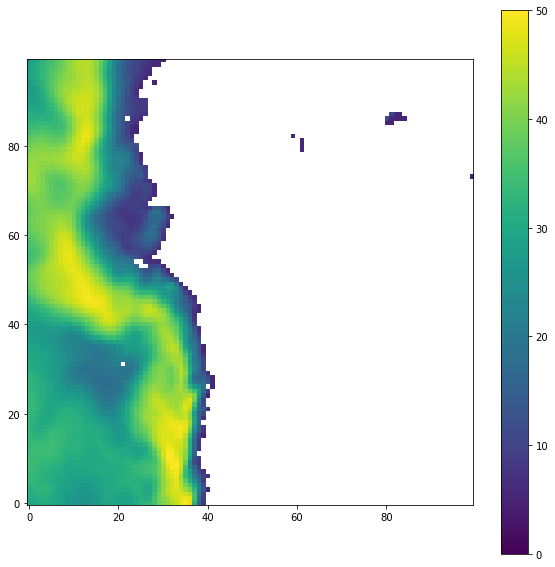

In [422]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
norm = matplotlib.colors.Normalize(vmin=0., vmax=50., clip=False)
dBZ = ax.imshow(gridded_radar_subgrid['reflectivity_masked'], origin='lower', vmin=0., vmax=50., norm=norm)
fig.colorbar(dBZ, ax=ax)

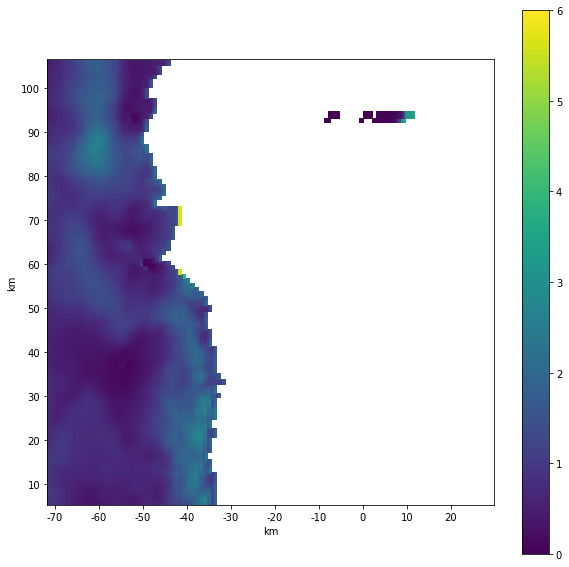

In [423]:
fig, ax = plt.subplots(figsize=(10, 10))
plotvarBin = ZDRBin 

clevels = np.arange(0., 6.1, 0.1)
vmin = clevels[0]
vmax = clevels[-1]
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
# plotvarBin = np.ma.masked_invalid(plotvarBin)
# plotvarBin = np.ma.masked_outside(plotvarBin, vmin, vmax)
    #plot=ax.pcolormesh(xedges,yedges,DmperBin.T,vmin=vmin,vmax=vmax,cmap=cm.jet,norm=norm,edgecolors='None',antialiased=False,rasterized=False)
plot=ax.pcolormesh(xedges, yedges, plotvarBin.T, cmap=cm.viridis, norm=norm, edgecolors='None',
                   antialiased=False, rasterized=False)
# plot=ax.pcolormesh(xedges, yedges, plotvarBin.T, cmap=cm.viridis, edgecolors='None',
#                    antialiased=False, rasterized=False)

fig.colorbar(plot, ax=ax)

formatter = ticker.FuncFormatter(mtokm)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10000.))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=10000.))
ax.set_xlim(x_flat.min(), x_flat.max())
ax.set_ylim(y_flat.min(), y_flat.max())
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_aspect('equal')

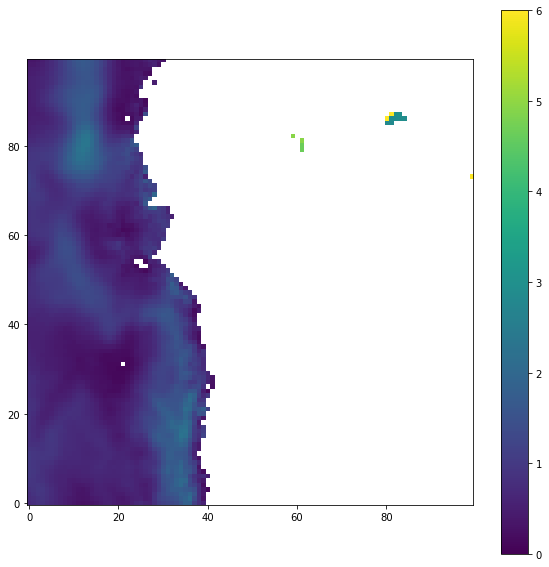

In [424]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
norm = matplotlib.colors.Normalize(vmin=0., vmax=6., clip=False)
dBZ = ax.imshow(gridded_radar_subgrid['differential_reflectivity_masked'], origin='lower', vmin=0., vmax=6., 
                norm=norm)
fig.colorbar(dBZ, ax=ax)